# Data Set


In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('store.csv', index_col=0)
data.head()

,REC,FRE,MON,CC_CARD,AVRG,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,PBLOUSES,PJACKETS,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
CUSTOMER,,,,,,,,,,,,,,,,,,,,,
1,208,2,368.46,0,184.23,0.18,0.00,0.00,0.30,0.0,...,N,0,5,0,0.00,31.81,111.00,10,0.00,0
2,6,4,258.00,1,64.50,0.26,0.16,0.00,0.00,0.0,...,Y,0,4,2,50.00,32.72,43.50,10,0.03,1
3,327,2,77.00,0,38.50,1.00,0.00,0.00,0.00,0.0,...,N,0,4,0,0.00,100.00,68.60,16,0.00,0
4,66,8,846.06,1,105.75,0.38,0.00,0.05,0.06,0.2,...,Y,0,9,6,66.67,23.27,26.96,10,0.00,0
5,49,1,87.44,0,87.44,0.20,0.20,0.00,0.00,0.0,...,Y,0,0,0,0.00,28.52,24.50,20,0.00,0


In [2]:
from sklearn.model_selection import train_test_split

SID = 490411065
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.6, random_state=SID, stratify=data['RESP'])
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

# 1. Exploratory Data Analysis


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

# Plot settings
sns.set_context('notebook')  # optimises figures for notebook display
sns.set_style('ticks')  # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)  # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams.update({'font.size': 16})

In [373]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgbm
from mlxtend.regressor import StackingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

ten_fold_shuffle = KFold(5, shuffle=True, random_state=100)

Below three cells create a custom scorer to take into account the different losses associated with FPs and FNs. Used later during machine learning.

In [50]:
def score_func(y, y_pred):
    loss = 3*((y_pred != y) & (y_pred == 0)) + 1*((y_pred != y) & (y_pred ==  1))
    return np.mean(loss)

In [51]:
score_func(train['RESP'], np.zeros(len(train)))  # baseline

0.4978145847711065

In [52]:
one_three = make_scorer(score_func, greater_is_better=False)

How balanced are the response classes?

0    83.386998
1    16.613002
Name: RESP, dtype: float64


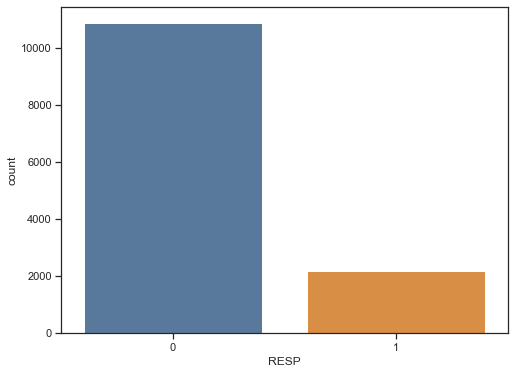

In [29]:
sns.countplot(x='RESP', data=train)
print(train['RESP'].value_counts()/len(train)*100)

This is the only non-numeric categorical feature in the data, so let's just make it numeric (binary)

In [14]:
train['VALPHON'] = train['VALPHON'].map({'Y': 1, 'N': 0}).astype(int)

Plotting each feature against the response

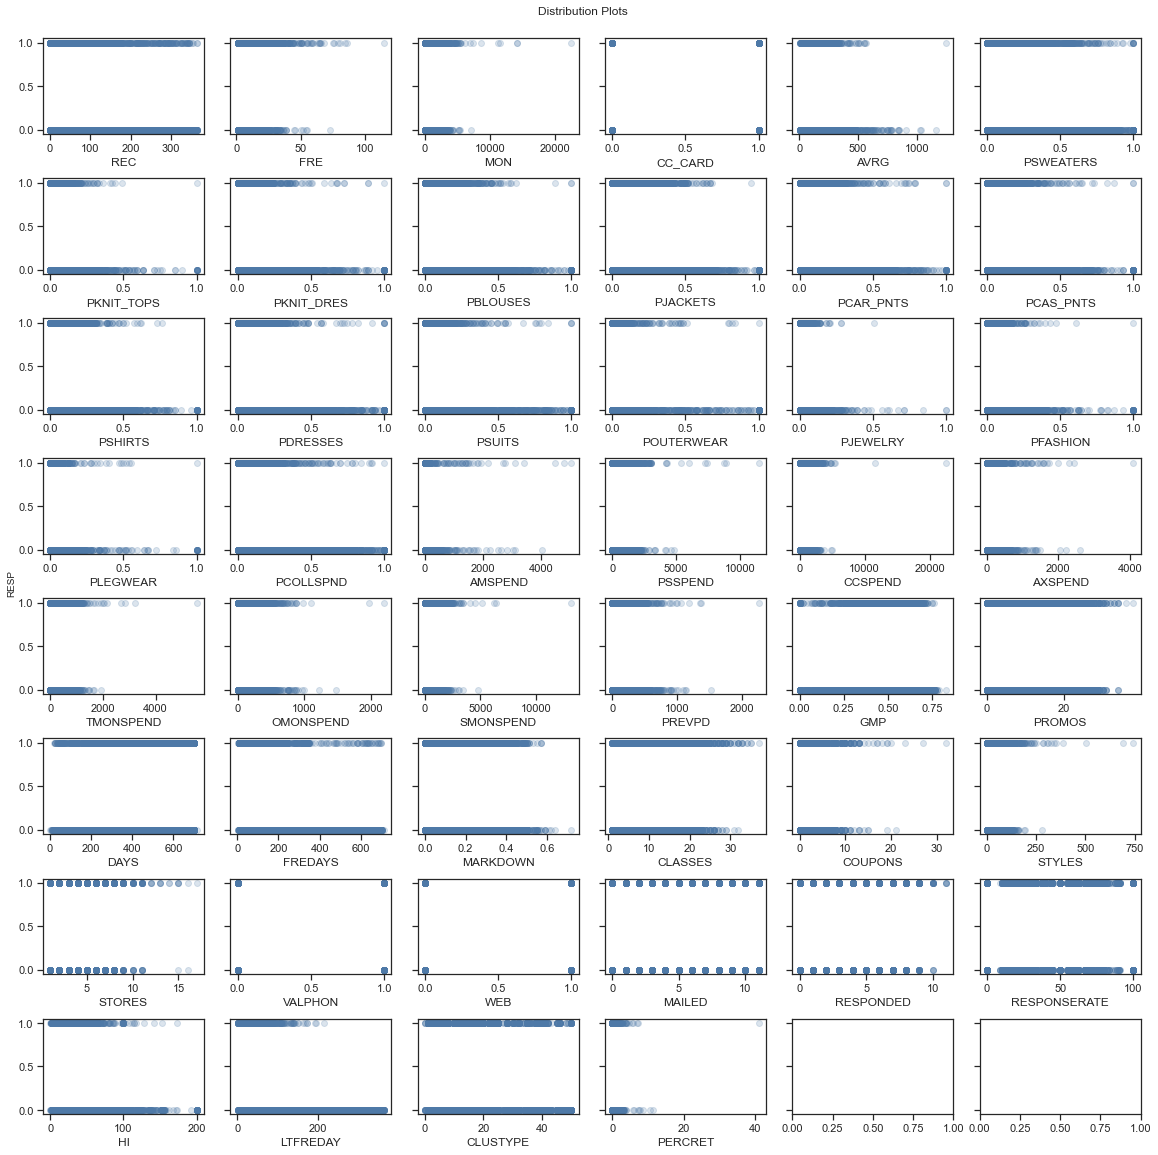

In [6]:
r = 8
c = 6
n = 46  # n <= r*c

fig, ax = plt.subplots(r, c, figsize=(16, 16), sharey=True)

for i in range(r):
    for j in range(c):
        if i*c+j+1 <= n:
            curr_var = train.iloc[:, i*c+j]
            #sns.displot(data=train, x=curr_var, hue='RESP', kind='kde', ax=ax[i, j])
            ax[i, j].scatter(curr_var, train['RESP'], alpha=0.2)
            ax[i, j].set_xlabel(curr_var.name)
            ax[i, j].set_ylabel('')
            
fig.suptitle('Distribution Plots', y=1)
fig.text(0, 0.5, 'RESP', va='center', rotation='vertical')
fig.tight_layout()
fig.show()

Density plots of continuous features

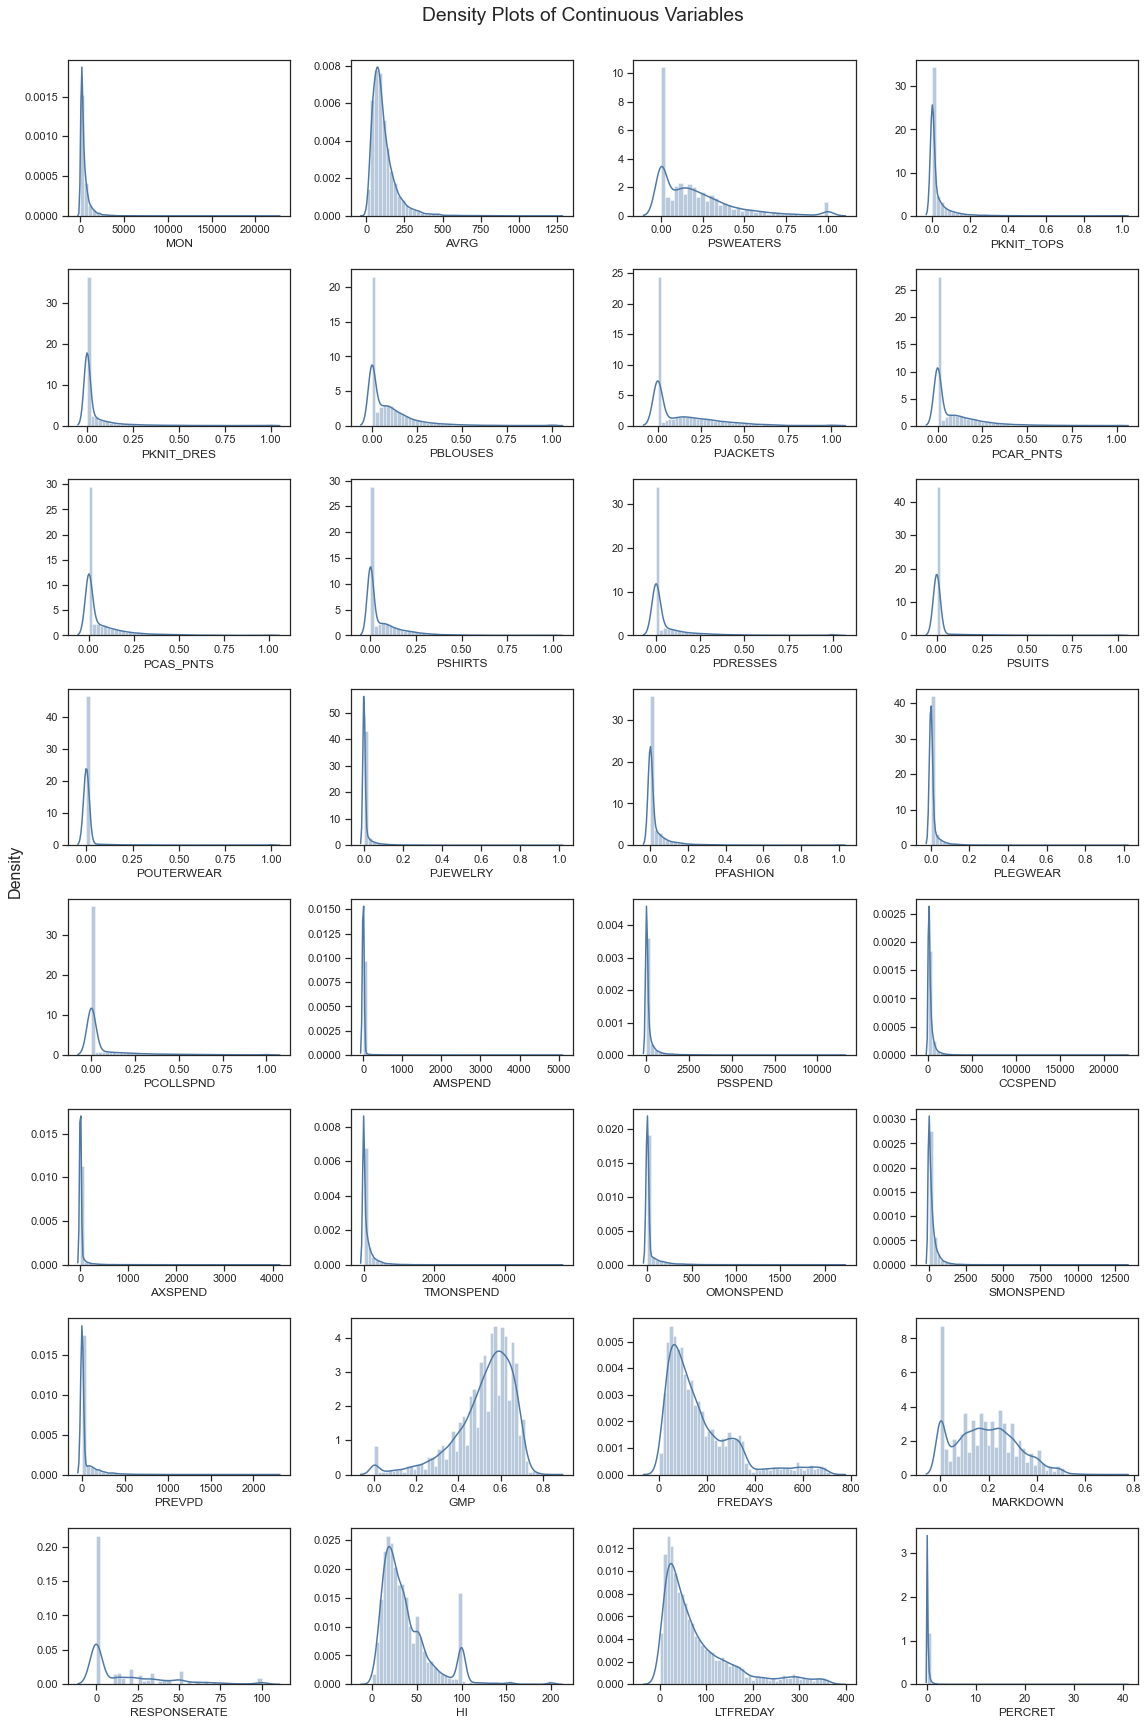

In [276]:
r = 8
c = 4
n = 32  # n <= r*c

fig, ax = plt.subplots(r, c, figsize=(16, 24))

for i in range(r):
    for j in range(c):
        if i*c+j+1 <= n:
            curr_var = train.select_dtypes('float64').iloc[:, i*c+j]
            sns.distplot(curr_var, ax=ax[i, j])
            ax[i, j].set_ylabel('')
            
fig.suptitle('Density Plots of Continuous Variables', y=1)
fig.text(0, 0.5, 'Density', va='center', rotation='vertical')
fig.tight_layout()
fig.show()

Density plots of discrete/binary features

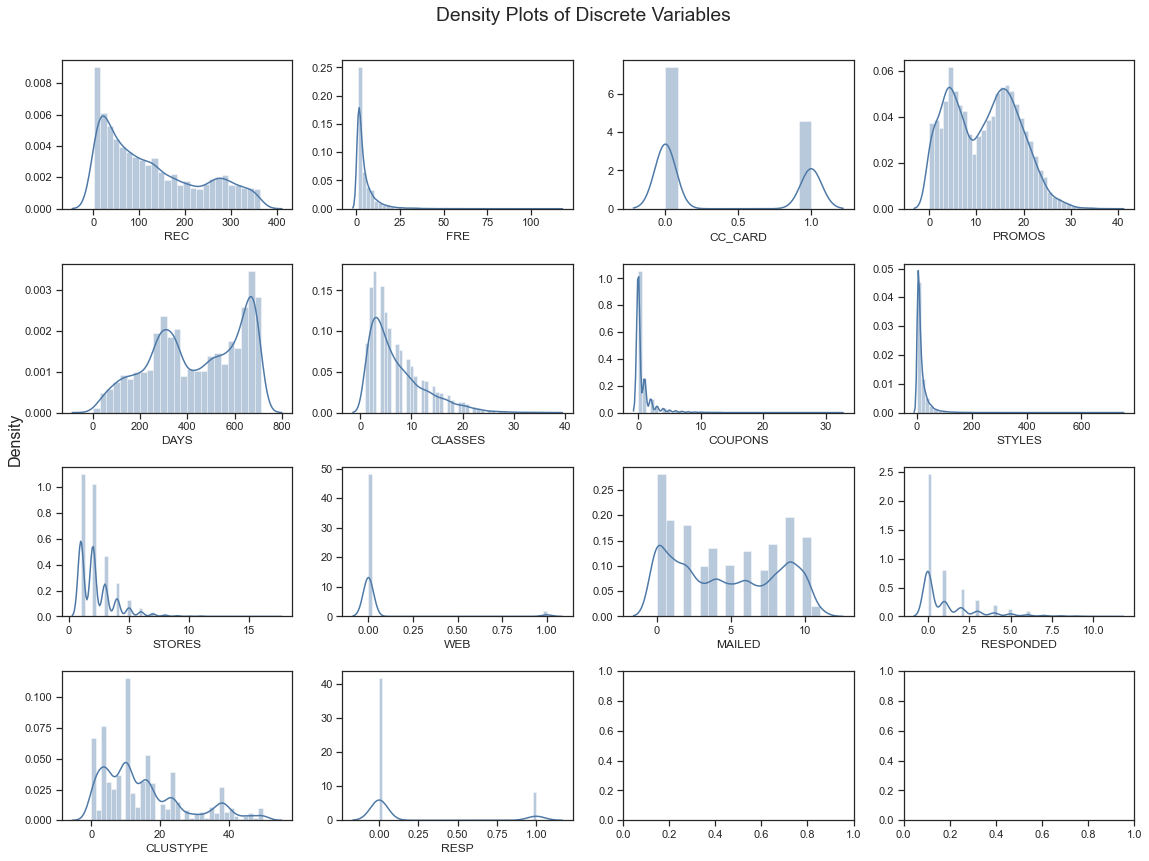

In [277]:
r = 4
c = 4
n = 14  # n <= r*c

fig, ax = plt.subplots(r, c, figsize=(16, 12))

for i in range(r):
    for j in range(c):
        if i*c+j+1 <= n:
            curr_var = train.select_dtypes('int64').iloc[:, i*c+j]
            sns.distplot(curr_var, ax=ax[i, j])
            ax[i, j].set_ylabel('')
            
fig.suptitle('Density Plots of Discrete Variables', y=1)
fig.text(0, 0.5, 'Density', va='center', rotation='vertical')
fig.tight_layout()
fig.show()

# 2. Feature Engineering


These values are too extreme

In [31]:
train[train['MON'] > 20000]

,REC,FRE,MON,CC_CARD,AVRG,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,PBLOUSES,PJACKETS,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
CUSTOMER,,,,,,,,,,,,,,,,,,,,,
6269,12,41,22511.49,1,549.06,0.18,0.01,0.03,0.1,0.14,...,1,0,10,9,90.0,8.32,5.14,10,0.33,1


In [32]:
train[train['FRE'] > 100]

,REC,FRE,MON,CC_CARD,AVRG,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,PBLOUSES,PJACKETS,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
CUSTOMER,,,,,,,,,,,,,,,,,,,,,
1259,7,115,3462.87,1,30.11,0.05,0.02,0.01,0.03,0.03,...,1,0,11,6,54.55,1.01,2.07,10,2.62,1


In [33]:
train[(train['AVRG'] > 1000) & (train['RESP'] == 1)]

,REC,FRE,MON,CC_CARD,AVRG,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,PBLOUSES,PJACKETS,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
CUSTOMER,,,,,,,,,,,,,,,,,,,,,
14761,41,1,1248.14,1,1248.14,0.25,0.02,0.06,0.2,0.12,...,1,0,0,0,0.0,15.34,2.92,4,0.03,1


Remove these outliers

In [15]:
train = train.drop([6269, 1259, 14761])

Build new features based on whether a corresponding feature is greater than 0 or not

In [16]:
for col in train.select_dtypes('float64').loc[:, 'PSWEATERS':'PREVPD'].columns:
    train[col + '>0'] = np.where(train[col] > 0, 1, 0)

Build new feature based on whether HI is equal to 100 or not

In [17]:
train['HI=100'] = np.where(train['HI'] == 100, 1, 0)

Build new feature based on whether PROMOS is greater than 10 or not

In [18]:
train['PROMOS>10'] = np.where(train['PROMOS'] > 10, 1, 0)

Build new feature based on whether DAYS is greater than 400 or not

In [19]:
train['DAYS>400'] = np.where(train['DAYS'] > 400, 1, 0)

Yeo-Johnson transformations of skewed features (all continuous + selected discrete)

In [21]:
skewed = list(train.select_dtypes('float64').columns) + ['REC', 'FRE', 'STYLES'] 

yj = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)
yj.fit(train[skewed])
train[skewed] = yj.transform(train[skewed])

Correlation heatmap of continuous features

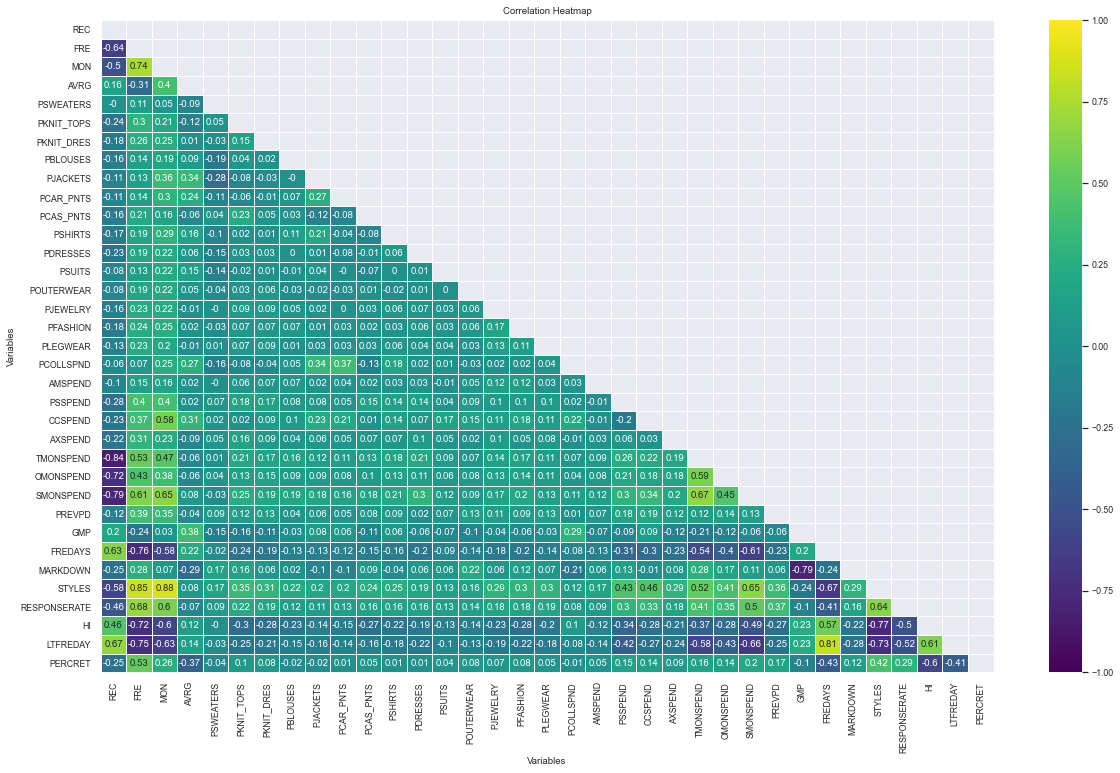

In [41]:
correlations = train.select_dtypes('float64').corr().round(2)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=0.8)
plt.figure(figsize=(20, 12))
sns.heatmap(correlations, cmap='viridis', vmin=-1, vmax=1, mask=mask, linewidths=0.5, annot=True)
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Correlation Heatmap')
plt.show()

Analyse scatter plots of pairs of features with |correlation| > 0.8

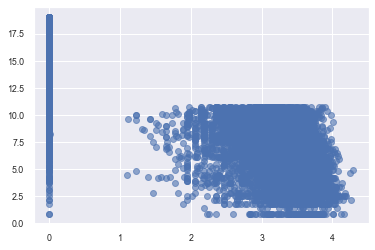

In [24]:
plt.scatter(train['TMONSPEND'], train['REC'], alpha=0.6)
plt.xlabel('')
plt.ylabel('')
plt.show()

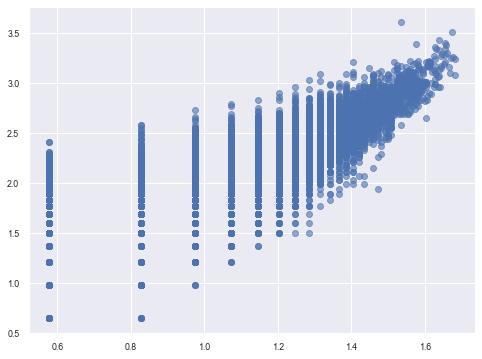

In [45]:
plt.scatter(train['FRE'], train['STYLES'], alpha=0.6)
plt.xlabel('')
plt.ylabel('')
plt.show()

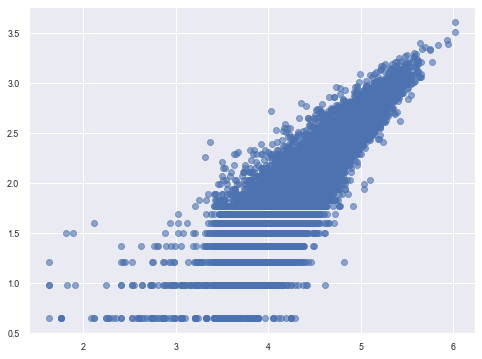

In [46]:
plt.scatter(train['MON'], train['STYLES'], alpha=0.6)
plt.xlabel('')
plt.ylabel('')
plt.show()

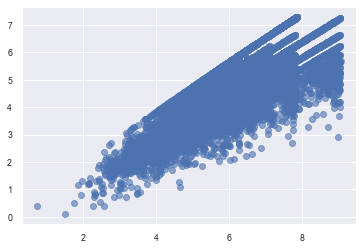

In [23]:
plt.scatter(train['FREDAYS'], train['LTFREDAY'], alpha=0.6)
plt.xlabel('')
plt.ylabel('')
plt.show()

Correlation heatmap of discrete features

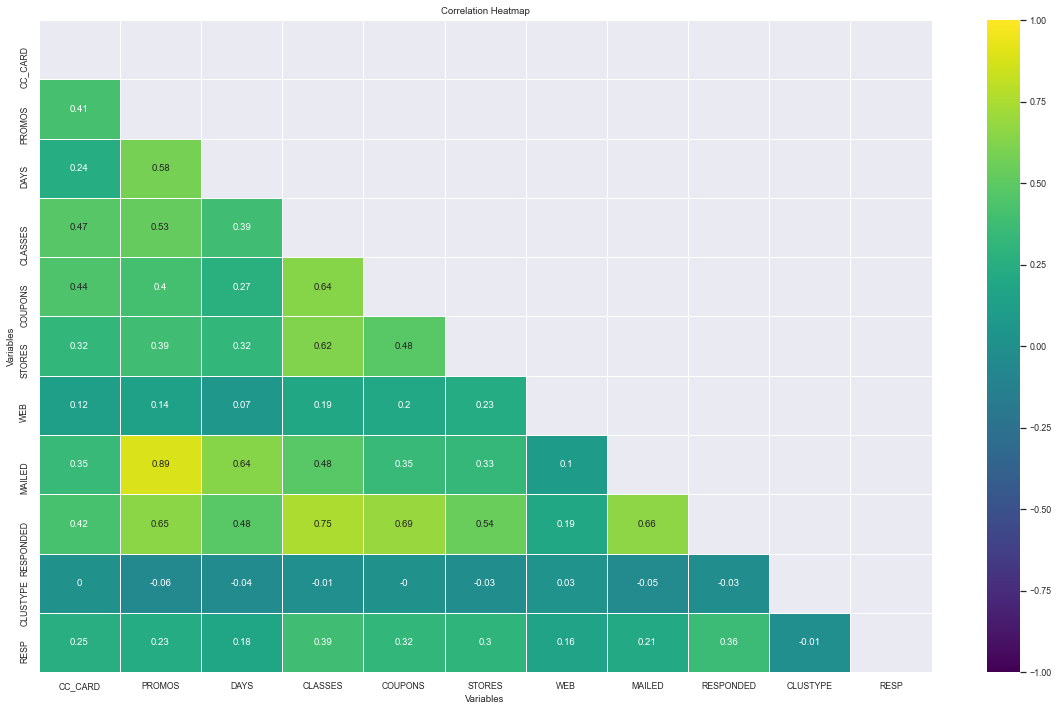

In [42]:
correlations = train.select_dtypes('int64').corr().round(2)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=0.8)
plt.figure(figsize=(20, 12))
sns.heatmap(correlations, cmap='viridis', vmin=-1, vmax=1, mask=mask, linewidths=0.5, annot=True)
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Correlation Heatmap')
plt.show()

Analyse scatter plots of pairs of features with |correlation| > 0.8

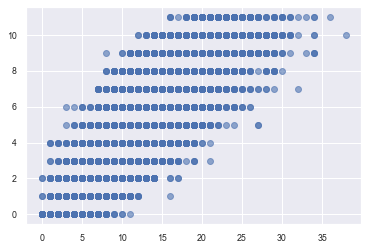

In [132]:
plt.scatter(train['PROMOS'], train['MAILED'], alpha=0.6)
plt.xlabel('')
plt.ylabel('')
plt.show()

Correlation heatmap of binary features

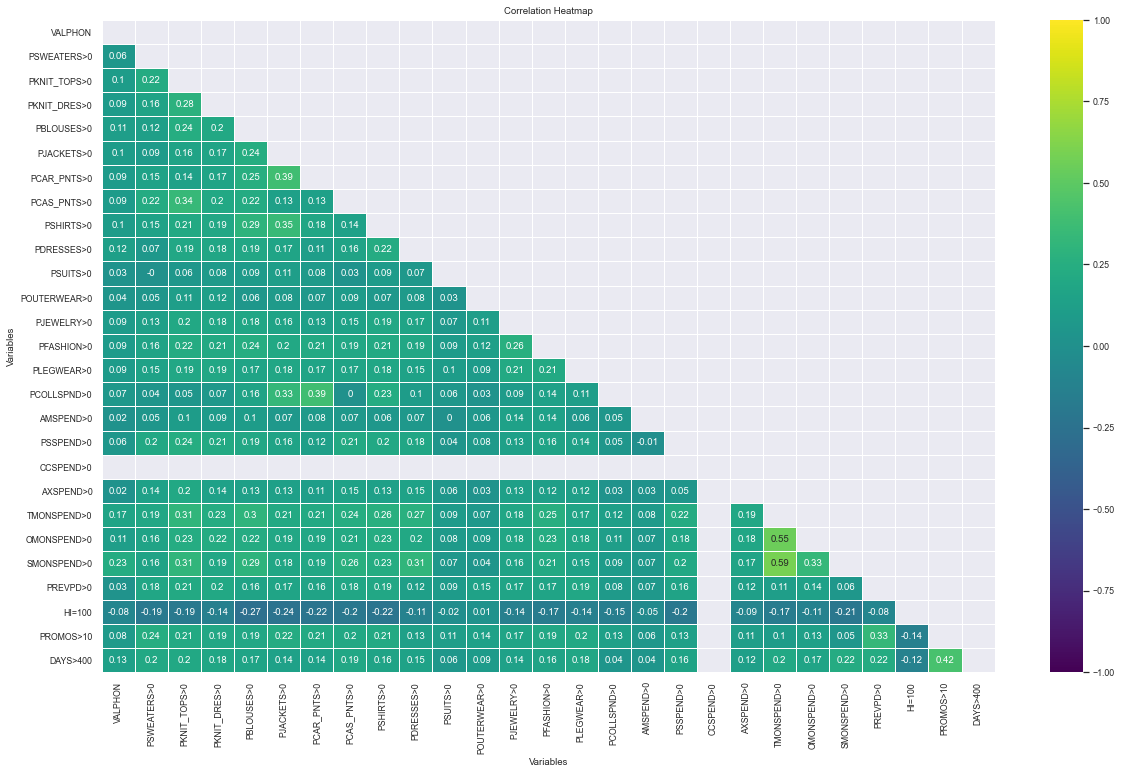

In [43]:
correlations = train.select_dtypes('int32').corr().round(2)
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=0.8)
plt.figure(figsize=(20, 12))
sns.heatmap(correlations, cmap='viridis', vmin=-1, vmax=1, mask=mask, linewidths=0.5, annot=True)
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Correlation Heatmap')
plt.show()

Remove this feature because it has all 1s

In [22]:
train = train.drop('CCSPEND>0', axis='columns')

Remove these features due to high correlation (and from analysing above scatter plots)

In [23]:
train = train.drop(['STYLES', 'FREDAYS', 'MAILED'], axis='columns')

# 3. Linear Model

### 3.1 Best linear model

Logistic regression with LASSO penalty; features standardised beforehand. Only top 25% features used.

In [564]:
logistic_l1_top.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=3.3, class_weight={0: 1, 1: 3},
                                    penalty='l1', solver='liblinear'))])

### 3.2 Code used to search for best linear model

Logistic regression with LASSO penalty and all features; features standardised beforehand

In [104]:
logistic_l1 = GridSearchCV(estimator=make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', class_weight={0:1, 1:3}, solver='liblinear')),
                    param_grid={'logisticregression__C': [0.1, 0.33, 1, 3.3, 10, 33, 100]},
                    scoring=one_three,
                    cv=ten_fold_shuffle,
                    n_jobs=-1)

logistic_l1.fit(train.drop('RESP', axis='columns'), train['RESP'])
np.min(-logistic_l1.cv_results_['mean_test_score'])

0.30350356364354625

Logistic regression with ridge penalty and all features; features standardised beforehand

In [105]:
logistic_l2 = GridSearchCV(estimator=make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', class_weight={0:1, 1:3}, solver='liblinear')),
                    param_grid={'logisticregression__C': [0.1, 0.33, 1, 3.3, 10, 33, 100]},
                    scoring=one_three,
                    cv=ten_fold_shuffle,
                    n_jobs=-1)

logistic_l2.fit(train.drop('RESP', axis='columns'), train['RESP'])
np.min(-logistic_l2.cv_results_['mean_test_score'])

0.3064942436163634

Logistic regression with LASSO penalty and top 25% features; features standardised beforehand
- **This was the best linear model**

In [329]:
logistic_l1_top = GridSearchCV(estimator=make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', class_weight={0:1, 1:3}, solver='liblinear')),
                    param_grid={'logisticregression__C': [0.1, 0.33, 1, 3.3, 10, 33, 100]},
                    scoring=one_three,
                    cv=ten_fold_shuffle,
                    n_jobs=-1)

logistic_l1_top.fit(train[top_vars], train['RESP'])
np.min(-logistic_l1_top.cv_results_['mean_test_score'])

0.2997463358313718

Logistic regression with ridge penalty and top 25% features; features standardised beforehand

In [330]:
logistic_l2_top = GridSearchCV(estimator=make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', class_weight={0:1, 1:3}, solver='liblinear')),
                    param_grid={'logisticregression__C': [0.1, 0.33, 1, 3.3, 10, 33, 100]},
                    scoring=one_three,
                    cv=ten_fold_shuffle,
                    n_jobs=-1)

logistic_l2_top.fit(train[top_vars], train['RESP'])
np.min(-logistic_l2_top.cv_results_['mean_test_score'])

0.2998230229479362

# 4. Tree-based model

### 4.1 Best tree-based model

XGBoost model with all features and alpha, gamma, learning_rate, colsample_bytree and max_depth are tweaked

In [571]:
xgb_alpha.best_estimator_

XGBClassifier(alpha=2.00815079528352, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              gamma=17.462341858588836, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=14, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=2.00815082,
              reg_lambda=1, scale_pos_weight=3, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### 4.2 Code used to search for best tree-based model

Random forest with focus on min_samples_split. All features used.

In [106]:
search_spaces = {
    'max_features': Real(0.1, 0.8),
    'max_depth': Integer(5, 100),
    'min_samples_split': Integer(2, 15),
}

rf_split = BayesSearchCV(estimator=RandomForestClassifier(n_estimators=500, class_weight={0:1, 1:3}),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

rf_split.fit(train.drop('RESP', axis='columns'), train['RESP'])
np.min(-np.array(rf_split.cv_results_['mean_test_score']))

0.3054980446284794

Random forest with focus on min_samples_leaf. All features used.

In [107]:
search_spaces = {
    'max_features': Real(0.1, 0.8),
    'max_depth': Integer(5, 100),
    'min_samples_leaf': Integer(1, 15),
}

rf_leaf = BayesSearchCV(estimator=RandomForestClassifier(n_estimators=500, class_weight={0:1, 1:3}),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

rf_leaf.fit(train.drop('RESP', axis='columns'), train['RESP'])
np.min(-np.array(rf_leaf.cv_results_['mean_test_score']))

0.3019707077678092

XGBoost with focus on alpha. All features used.
- **This was the best tree-based model**

In [291]:
search_spaces = {
    'learning_rate': Real(0.01, 0.99),
    'max_depth': Integer(3, 15),
    'gamma': Real(0.001, 100),
    'colsample_bytree': Real(0.1, 0.9),
    'alpha': Real(0.01, 10)
}

xgb_alpha = BayesSearchCV(estimator=xgb.XGBClassifier(n_estimators=500, scale_pos_weight=3),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

xgb_alpha.fit(train.drop('RESP', axis='columns'), train['RESP'])
np.min(-np.array(xgb_alpha.cv_results_['mean_test_score']))

[13:38:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.29967027068476343

XGBoost with focus on lambda. All features used.

In [292]:
search_spaces = {
    'learning_rate': Real(0.01, 0.99),
    'max_depth': Integer(3, 15),
    'gamma': Real(0.001, 100),
    'colsample_bytree': Real(0.1, 0.9),
    'lambda': Real(0.01, 10)
}

xgb_lambda = BayesSearchCV(estimator=xgb.XGBClassifier(n_estimators=500, scale_pos_weight=3),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

xgb_lambda.fit(train.drop('RESP', axis='columns'), train['RESP'])
np.min(-np.array(xgb_lambda.cv_results_['mean_test_score']))

[13:45:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.3035043324898397

LightGBM model. All features used.

In [293]:
search_spaces = {
    'learning_rate': Real(0.01, 0.99),
    'num_leaves': Integer(10, 100),
    'colsample_bytree': Real(0.1, 0.9),
    'reg_alpha': Real(0.001, 100),
    'reg_lambda': Real(0.001, 100)
}

lgb = BayesSearchCV(estimator=lgbm.LGBMClassifier(n_estimators=500, class_weight={0:1, 1:3}),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

lgb.fit(train.drop('RESP', axis='columns'), train['RESP'])
np.min(-np.array(lgb.cv_results_['mean_test_score']))

0.30289088260102753

Gather together feature importances of all currently trained models, and compute the average feature importance for each feature

In [294]:
feat_imp = pd.DataFrame({'feature': train.drop('RESP', axis='columns').columns,
                        'logistic_l1': (abs(logistic_l1.best_estimator_[1].coef_)/np.sum(abs(logistic_l1.best_estimator_[1].coef_)))[0],
                        'logistic_l2': (abs(logistic_l2.best_estimator_[1].coef_)/np.sum(abs(logistic_l2.best_estimator_[1].coef_)))[0],
                        'rf_split': rf_split.best_estimator_.feature_importances_,
                        'rf_leaf': rf_leaf.best_estimator_.feature_importances_,
                        'xgb_alpha': xgb_alpha.best_estimator_.feature_importances_,
                        'xgb_lambda': xgb_lambda.best_estimator_.feature_importances_,
                        'lgb': lgb.best_estimator_.feature_importances_/np.sum(lgb.best_estimator_.feature_importances_)})

In [295]:
feat_imp['average'] = feat_imp.iloc[:, 1:].mean(axis='columns')

Plot average feature importance

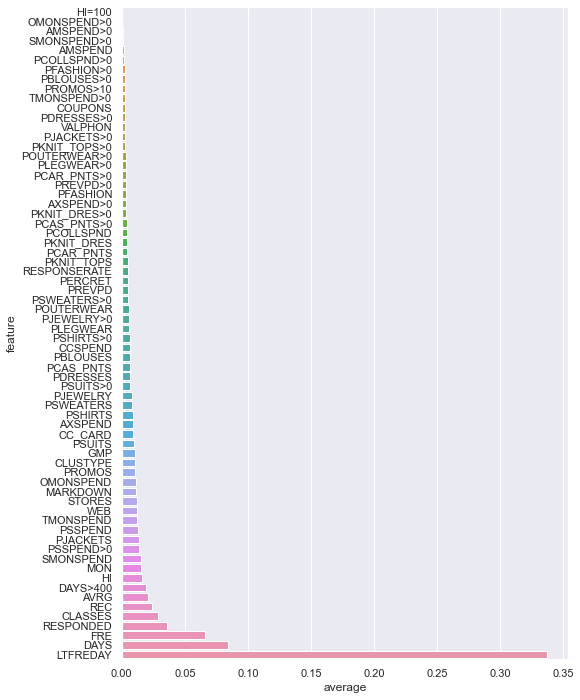

In [301]:
fig, ax = plt.subplots(1, 1, figsize=(8,12))
sns.barplot(feat_imp.sort_values('average')['average'], feat_imp.sort_values('average')['feature'])
plt.show()

Decide to extract the top 25% important features. Models in previous sections based on only the top 25% features are trained in retrospect.

In [331]:
top_vars = feat_imp.sort_values('average').iloc[51:]['feature']

Random forest with focus on min_samples_split. Only top 25% features used.

In [486]:
search_spaces = {
    'max_features': Real(0.1, 0.8),
    'max_depth': Integer(5, 100),
    'min_samples_split': Integer(2, 15),
}

rf_split_top = BayesSearchCV(estimator=RandomForestClassifier(n_estimators=500, class_weight={0:1, 1:3}),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

rf_split_top.fit(train[top_vars], train['RESP'])
np.min(-np.array(rf_split_top.cv_results_['mean_test_score']))

0.3031976075454336

Random forest with focus on min_samples_leaf. Only top 25% features used.

In [487]:
search_spaces = {
    'max_features': Real(0.1, 0.8),
    'max_depth': Integer(5, 100),
    'min_samples_leaf': Integer(1, 15),
}

rf_leaf_top = BayesSearchCV(estimator=RandomForestClassifier(n_estimators=500, class_weight={0:1, 1:3}),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

rf_leaf_top.fit(train[top_vars], train['RESP'])
np.min(-np.array(rf_leaf_top.cv_results_['mean_test_score']))

0.3037343761981443

XGBoost with focus on alpha. Only top 25% features used.

In [488]:
search_spaces = {
    'learning_rate': Real(0.01, 0.99),
    'max_depth': Integer(3, 15),
    'gamma': Real(0.001, 100),
    'colsample_bytree': Real(0.1, 0.9),
    'alpha': Real(0.01, 10)
}

xgb_alpha_top = BayesSearchCV(estimator=xgb.XGBClassifier(n_estimators=500, scale_pos_weight=3),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

xgb_alpha_top.fit(train[top_vars], train['RESP'])
np.min(-np.array(xgb_alpha_top.cv_results_['mean_test_score']))

[17:02:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.30335097001763667

XGBoost with focus on lambda. Only top 25% features used.

In [489]:
search_spaces = {
    'learning_rate': Real(0.01, 0.99),
    'max_depth': Integer(3, 15),
    'gamma': Real(0.001, 100),
    'colsample_bytree': Real(0.1, 0.9),
    'lambda': Real(0.01, 10)
}

xgb_lambda_top = BayesSearchCV(estimator=xgb.XGBClassifier(n_estimators=500, scale_pos_weight=3),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

xgb_lambda_top.fit(train[top_vars], train['RESP'])
np.min(-np.array(xgb_lambda_top.cv_results_['mean_test_score']))

[17:05:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.3018940265317077

LightGBM model. Only top 25% features used.

In [490]:
search_spaces = {
    'learning_rate': Real(0.01, 0.99),
    'num_leaves': Integer(10, 100),
    'colsample_bytree': Real(0.1, 0.9),
    'reg_alpha': Real(0.001, 100),
    'reg_lambda': Real(0.001, 100)
}

lgb_top = BayesSearchCV(estimator=lgbm.LGBMClassifier(n_estimators=500, class_weight={0:1, 1:3}),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

lgb_top.fit(train[top_vars], train['RESP'])
np.min(-np.array(lgb_top.cv_results_['mean_test_score']))

0.3035043324898397

# 5. Neural Network

In [740]:
stdz = StandardScaler()
X = stdz.fit_transform(train.drop('RESP', axis='columns'))  # standardisation helps convergence

Write a function to use with GridSearchCV

In [621]:
def build_model(opt, drop, regA, regB):
    
    inputs = keras.Input(shape=(X.shape[1],))

    hidden1 = layers.Dense(128, kernel_initializer='lecun_normal', activation='selu', kernel_regularizer=regularizers.l2(regA))(inputs)
    hidden2 = layers.Dropout(drop)(hidden1)
    hidden3 = layers.Dense(128, kernel_initializer='lecun_normal', activation='selu', kernel_regularizer=regularizers.l2(regB))(hidden2)

    output = layers.Dense(1, activation='sigmoid')(hidden3)

    dfn = keras.Model(inputs=inputs, outputs=output)
    dfn.compile(loss='binary_crossentropy', optimizer=opt)
    
    return dfn

Select hyperparameters via cross-validation (using binary cross-entropy as loss function)

In [628]:
param_grid={
    'epochs': [20, 100],
    'batch_size': [128, 512],
    'opt': ['Adam', 'RMSprop'],
    'drop': [0.2, 0.5],
    'regA': [0.0001, 0.01],
    'regB': [0.0001, 0.01],
}

neural_net = GridSearchCV(estimator=KerasRegressor(build_fn=build_model, class_weight={0:1, 1:3}, verbose=0),
                          param_grid=param_grid,
                          cv=ten_fold_shuffle,
                          n_jobs=-1)

neural_net.fit(X, train['RESP'])
np.min(-neural_net.cv_results_['mean_test_score'])

0.4119288265705109

In [635]:
neural_net.best_params_

{'batch_size': 512,
 'drop': 0.2,
 'epochs': 100,
 'opt': 'Adam',
 'regA': 0.0001,
 'regB': 0.01}

Visualise training and validation error for model selected above as epochs increase

In [640]:
dfn = build_model('Adam', 0.2, 0.0001, 0.01)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, 
                                         patience=15, verbose=1)

dfn.fit(X, 
        train['RESP'], 
        epochs=500,
        batch_size=512, 
        validation_split=0.4,
        callbacks=[earlystopping],
        class_weight={0:1, 1:3},
        verbose=2)

Epoch 1/500
16/16 - 0s - loss: 2.2418 - val_loss: 1.7343
Epoch 2/500
16/16 - 0s - loss: 1.8936 - val_loss: 1.5308
Epoch 3/500
16/16 - 0s - loss: 1.7149 - val_loss: 1.4034
Epoch 4/500
16/16 - 0s - loss: 1.5869 - val_loss: 1.2881
Epoch 5/500
16/16 - 0s - loss: 1.4820 - val_loss: 1.1904
Epoch 6/500
16/16 - 0s - loss: 1.3912 - val_loss: 1.1067
Epoch 7/500
16/16 - 0s - loss: 1.3125 - val_loss: 1.0459
Epoch 8/500
16/16 - 0s - loss: 1.2355 - val_loss: 0.9607
Epoch 9/500
16/16 - 0s - loss: 1.1731 - val_loss: 0.9153
Epoch 10/500
16/16 - 0s - loss: 1.1082 - val_loss: 0.8666
Epoch 11/500
16/16 - 0s - loss: 1.0580 - val_loss: 0.8144
Epoch 12/500
16/16 - 0s - loss: 1.0112 - val_loss: 0.7745
Epoch 13/500
16/16 - 0s - loss: 0.9790 - val_loss: 0.7416
Epoch 14/500
16/16 - 0s - loss: 0.9374 - val_loss: 0.7048
Epoch 15/500
16/16 - 0s - loss: 0.9135 - val_loss: 0.6702
Epoch 16/500
16/16 - 0s - loss: 0.8871 - val_loss: 0.6338
Epoch 17/500
16/16 - 0s - loss: 0.8631 - val_loss: 0.6172
Epoch 18/500
16/16 - 0s

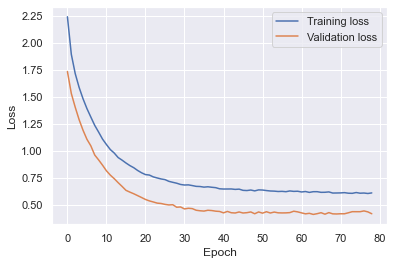

In [648]:
plt.plot(dfn.history.history['loss'], label='Training loss')
plt.plot(dfn.history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Mean train loss for selected neural network model

In [655]:
y_pred = (dfn.predict(X) > 0.5).astype(int)
y_pred = np.array([i[0] for i in y_pred])

In [656]:
score_func(train['RESP'], y_pred)

0.28433402346445824

# 6. Additional models

### 6.1 Code for the best additional model

Stacked regression with a logistic regression, a random forest and an XGBoost as initial models, and another logistic regression as the meta model. All features used.

In [ ]:
stack_narrow = StackingRegressor(regressors=[logistic_l1.best_estimator_,
                                            rf_leaf.best_estimator_,
                                            xgb_alpha.best_estimator_], 
                            meta_regressor=LogisticRegression(penalty='l2', C=1000, class_weight={0:1, 1:3}, solver='liblinear'))

In [569]:
stack_narrow.regressors  # first level models 

[Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=0.1, class_weight={0: 1, 1: 3},
                                     penalty='l1', solver='liblinear'))]),
 RandomForestClassifier(class_weight={0: 1, 1: 3}, max_depth=6,
                        max_features=0.7028389686539465, n_estimators=500),
 XGBClassifier(alpha=2.00815079528352, base_score=0.5, booster='gbtree',
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
               gamma=17.462341858588836, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.01, max_delta_step=0,
               max_depth=14, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=500, n_jobs=12,
               num_parallel_tree=1, random_state=0, reg_alpha=2.00815082,
               reg_lambda=1, scale_pos_weight=3, subsample=1,
               tree_method='exact', valida

In [568]:
stack_narrow.meta_regressor  # second level meta model

LogisticRegression(C=1000, class_weight={0: 1, 1: 3}, solver='liblinear')

In [712]:
stack_narrow.coef_  # coefficients of meta model

array([[-0.29711488, -0.1233487 ,  3.50002686]])

### 6.2 Code used to search for best additional model

XGBoost with linear boosters and all features

In [338]:
search_spaces = {
    'alpha': Real(0.01, 10),
    'lambda': Real(0.01, 10)
}

xgb_linear = BayesSearchCV(estimator=xgb.XGBClassifier(n_estimators=500, booster='gblinear', scale_pos_weight=3),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

xgb_linear.fit(train.drop('RESP', axis='columns'), train['RESP'])
np.min(-np.array(xgb_linear.cv_results_['mean_test_score']))

[14:31:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.3054213633923779

XGBoost with linear boosters and top 25% features

In [340]:
search_spaces = {
    'alpha': Real(0.01, 10),
    'lambda': Real(0.01, 10)
}

xgb_linear_top = BayesSearchCV(estimator=xgb.XGBClassifier(n_estimators=500, booster='gblinear', scale_pos_weight=3),
                     search_spaces=search_spaces,
                     scoring=one_three,
                     cv=ten_fold_shuffle,
                     n_iter=20,
                     n_jobs=-1)

xgb_linear_top.fit(train[top_vars], train['RESP'])
np.min(-np.array(xgb_linear_top.cv_results_['mean_test_score']))

[14:33:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.3051913196840733

Gather together training set predictions of all models from previous sections (excluding neural networks) using all features

In [341]:
predictions = pd.DataFrame({'logistic_l1': logistic_l1.best_estimator_.predict(train.drop('RESP', axis='columns')),
                            'logistic_l2': logistic_l2.best_estimator_.predict(train.drop('RESP', axis='columns')),
                            'rf_split': rf_split.best_estimator_.predict(train.drop('RESP', axis='columns')),
                            'rf_leaf': rf_leaf.best_estimator_.predict(train.drop('RESP', axis='columns')),
                            'xgb_alpha': xgb_alpha.best_estimator_.predict(train.drop('RESP', axis='columns')),
                            'xgb_lambda': xgb_lambda.best_estimator_.predict(train.drop('RESP', axis='columns')),
                            'lgb': lgb.best_estimator_.predict(train.drop('RESP', axis='columns')),
                            'xgb_linear': xgb_linear.best_estimator_.predict(train.drop('RESP', axis='columns'))})

Correlation heatmap of above predictions

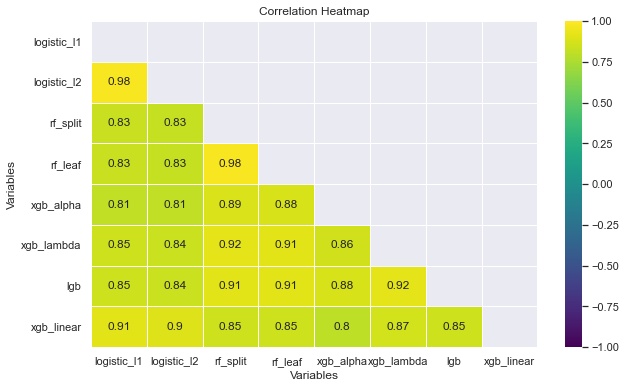

In [558]:
correlations = predictions.corr()
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1)
plt.figure(figsize=(10, 6))
sns.heatmap(correlations, cmap='viridis', vmin=-1, vmax=1, mask=mask, linewidths=0.5, annot=True)
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Correlation Heatmap')
plt.show()

Stacked model using all models from the above heatmap and a logistic regression as the meta model

In [560]:
stack_full = StackingRegressor(regressors=[logistic_l1.best_estimator_,
                                            logistic_l2.best_estimator_,
                                            rf_split.best_estimator_,
                                            rf_leaf.best_estimator_,
                                            xgb_alpha.best_estimator_,
                                            xgb_lambda.best_estimator_,
                                            lgb.best_estimator_,
                                            xgb_linear.best_estimator_], 
                            meta_regressor=LogisticRegression(penalty='l2', C=1000, class_weight={0:1, 1:3}, solver='liblinear'))

stack_full_scores = cross_val_score(estimator=stack_full, 
                                    X=train.drop('RESP', axis='columns'), y=train['RESP'],
                                    scoring=one_three,
                                    cv=ten_fold_shuffle,
                                    n_jobs=4)

np.mean(-stack_full_scores)

0.30350412211622346

Stacked model using the three least correlated models from the above heatmap and a logistic regression as the meta model
- **This was the best additional model**

In [561]:
stack_narrow = StackingRegressor(regressors=[logistic_l1.best_estimator_,
                                            rf_leaf.best_estimator_,
                                            xgb_alpha.best_estimator_], 
                            meta_regressor=LogisticRegression(penalty='l2', C=1000, class_weight={0:1, 1:3}, solver='liblinear'))

stack_narrow_scores = cross_val_score(estimator=stack_narrow, 
                                    X=train.drop('RESP', axis='columns'), y=train['RESP'],
                                    scoring=one_three,
                                    cv=ten_fold_shuffle,
                                    n_jobs=4)

np.mean(-stack_narrow_scores)

0.29967017779418575

Gather together training set predictions of all models from previous sections (excluding neural networks), this time only using top 25% features

In [556]:
predictions_top = pd.DataFrame({'logistic_l1_top': logistic_l1_top.best_estimator_.predict(train[top_vars]),
                            'logistic_l2_top': logistic_l2_top.best_estimator_.predict(train[top_vars]),
                            'rf_split_top': rf_split_top.best_estimator_.predict(train[top_vars]),
                            'rf_leaf_top': rf_leaf_top.best_estimator_.predict(train[top_vars]),
                            'xgb_alpha_top': xgb_alpha_top.best_estimator_.predict(train[top_vars]),
                            'xgb_lambda_top': xgb_lambda_top.best_estimator_.predict(train[top_vars]),
                            'lgb_top': lgb_top.best_estimator_.predict(train[top_vars]),
                            'xgb_linear_top': xgb_linear_top.best_estimator_.predict(train[top_vars])})

Correlation heatmap of above predictions

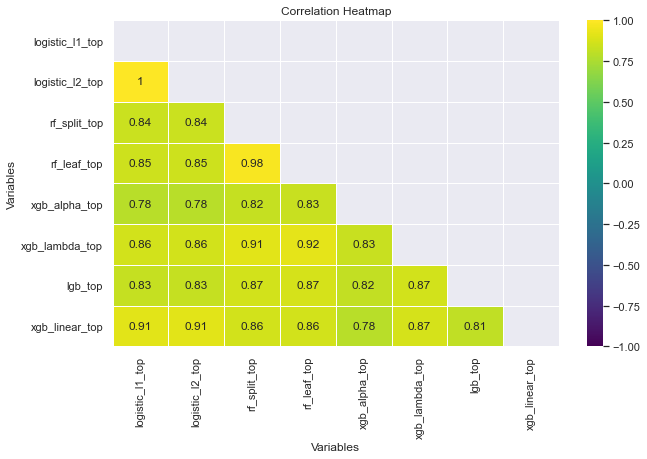

In [559]:
correlations = predictions_top.corr()
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1)
plt.figure(figsize=(10, 6))
sns.heatmap(correlations, cmap='viridis', vmin=-1, vmax=1, mask=mask, linewidths=0.5, annot=True)
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.title('Correlation Heatmap')
plt.show()

Stacked model using all models from the above heatmap and a logistic regression as the meta model

In [562]:
stack_full_top = StackingRegressor(regressors=[logistic_l1_top.best_estimator_,
                                            logistic_l2_top.best_estimator_,
                                            rf_split_top.best_estimator_,
                                            rf_leaf_top.best_estimator_,
                                            xgb_alpha_top.best_estimator_,
                                            xgb_lambda_top.best_estimator_,
                                            lgb_top.best_estimator_,
                                            xgb_linear_top.best_estimator_], 
                            meta_regressor=LogisticRegression(penalty='l2', C=1000, class_weight={0:1, 1:3}, solver='liblinear'))

stack_full_top_scores = cross_val_score(estimator=stack_full_top, 
                                    X=train[top_vars], y=train['RESP'],
                                    scoring=one_three,
                                    cv=ten_fold_shuffle,
                                    n_jobs=4)

np.mean(-stack_full_top_scores)

0.304730704475071

Stacked model using the three least correlated models from the above heatmap and a logistic regression as the meta model

In [563]:
stack_narrow_top = StackingRegressor(regressors=[logistic_l1_top.best_estimator_,
                                            rf_leaf_top.best_estimator_,
                                            xgb_alpha_top.best_estimator_], 
                            meta_regressor=LogisticRegression(penalty='l2', C=1000, class_weight={0:1, 1:3}, solver='liblinear'))

stack_narrow_top_scores = cross_val_score(estimator=stack_narrow_top, 
                                    X=train[top_vars], y=train['RESP'],
                                    scoring=one_three,
                                    cv=ten_fold_shuffle,
                                    n_jobs=4)

np.mean(-stack_narrow_top_scores)

0.3030439700235381

# 7. Model Selection

### 7.1 Code

Compute fitted values (training set predictions) for best model in each of the above sections

In [709]:
logistic_l1_top_pred = logistic_l1_top.best_estimator_.predict(train[top_vars])
xgb_alpha_pred = xgb_alpha.best_estimator_.predict(train.drop('RESP', axis='columns'))

temp = stack_narrow.fit(train.drop('RESP', axis='columns'), train['RESP'])
stack_narrow_pred = temp.predict(train.drop('RESP', axis='columns'))

temp = (dfn.predict(X) > 0.5).astype(int)
neural_net_pred = np.array([i[0] for i in temp])

### 7.2 Results

Mean CV loss and mean train loss for my 4 models

In [730]:
pd.DataFrame({'model': ['logistic_l1_top', 'xgb_alpha', 'stack_narrow', 'neural_net'],
              'mean_cv_loss': [np.min(-logistic_l1_top.cv_results_['mean_test_score']),
                               np.min(-np.array(xgb_alpha.cv_results_['mean_test_score'])),
                               np.mean(-stack_narrow_scores),
                               'N/A'],
              'mean_train_loss': [score_func(train['RESP'], logistic_l1_top_pred),
                             score_func(train['RESP'], xgb_alpha_pred),
                             score_func(train['RESP'], stack_narrow_pred),
                             score_func(train['RESP'], neural_net_pred)]})

,model,mean_cv_loss,mean_train_loss
0,logistic_l1_top,0.299746,0.297370
1,xgb_alpha,0.29967,0.219922
2,stack_narrow,0.29967,0.219922
3,neural_net,N/A,0.284334


# 8. Model Evaluation

### 8.1 Code

Feature engineer test data

In [657]:
test['VALPHON'] = test['VALPHON'].map({'Y': 1, 'N': 0}).astype(int)

for col in test.select_dtypes('float64').loc[:, 'PSWEATERS':'PREVPD'].columns:
    test[col + '>0'] = np.where(test[col] > 0, 1, 0)
    
test['HI=100'] = np.where(test['HI'] == 100, 1, 0)
test['PROMOS>10'] = np.where(test['PROMOS'] > 10, 1, 0)
test['DAYS>400'] = np.where(test['DAYS'] > 400, 1, 0)

skewed = list(test.select_dtypes('float64').columns) + ['REC', 'FRE', 'STYLES'] 
yj = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)
yj.fit(test[skewed])
test[skewed] = yj.transform(test[skewed])

test = test.drop('CCSPEND>0', axis='columns')
test = test.drop(['STYLES', 'FREDAYS', 'MAILED'], axis='columns')

Compute test set predictions using our final model

In [727]:
final_pred = logistic_l1_top.predict(test[top_vars])

In [719]:
TP = np.sum((final_pred == 1) & (test['RESP'] == 1))
TN = np.sum((final_pred == 0) & (test['RESP'] == 0))
FP = np.sum((final_pred == 1) & (test['RESP'] == 0))
FN = np.sum((final_pred == 0) & (test['RESP'] == 1))

Compute baseline predictions (predicting everything as 0)

In [725]:
baseline_pred = np.zeros(len(test))

In [728]:
TPb = np.sum((baseline_pred == 1) & (test['RESP'] == 1))
TNb = np.sum((baseline_pred == 0) & (test['RESP'] == 0))
FPb = np.sum((baseline_pred == 1) & (test['RESP'] == 0))
FNb = np.sum((baseline_pred == 0) & (test['RESP'] == 1))

### 8.2 Results

Confusion matrix for final predictions

In [720]:
pd.DataFrame(np.array([[TP, FP], [FN, TN]]), 
             index=['predict 1', 'predict 0'], 
             columns=['actual 1', 'actual 0'])

,actual 1,actual 0
predict 1,914,1198
predict 0,530,6054


Confusion matrix for baseline predictions

In [729]:
pd.DataFrame(np.array([[TPb, FPb], [FNb, TNb]]), 
             index=['predict 1', 'predict 0'], 
             columns=['actual 1', 'actual 0'])

,actual 1,actual 0
predict 1,0,0
predict 0,1444,7252


Different measures of accuracy on final model and baseline model

In [738]:
pd.DataFrame({'model': ['logistic_l1_top', 'baseline'],
              'mean_test_loss': [score_func(test['RESP'], final_pred),
                                 score_func(test['RESP'], baseline_pred)],
              'accuracy': [(TP+TN)/(TP+TN+FP+FN), 
                           (TPb+TNb)/(TPb+TNb+FPb+FNb)],
              'recall': [TP/(TP+FN), 
                         TPb/(TPb+FNb)],
              'specificity': [TN/(TN+FP), 
                              TNb/(TNb+FPb)],
              'precision': [TP/(TP+FP), 
                            TPb/(TPb+FPb)]}).round(3)

,model,mean_test_loss,accuracy,recall,specificity,precision
0,logistic_l1_top,0.311,0.801,0.633,0.835,0.433
1,baseline,0.498,0.834,0.000,1.000,NaN
